# BRDF Representation

## Mitsuba "Deep Dive"

In [356]:
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(mi.variants())
mi.set_variant("llvm_ad_rgb_double")

['scalar_mono', 'scalar_mono_double', 'scalar_rgb', 'scalar_spectral', 'llvm_ad_rgb', 'llvm_ad_rgb_double']


In [357]:
WHITECAP=1
GLINT=2
UNDERLIGHT=3
TOTAL=0

channels = [TOTAL, WHITECAP, GLINT, UNDERLIGHT]

In [358]:
res = 25
azim_vs = np.linspace(0, 2 * np.pi, 2 * res)
zen_vs = np.linspace(0, np.deg2rad(89), res)

wavelength = 3.9
incoming = 45
solar_azimuth = 0
wind_speed = 25
wind_direction = np.deg2rad(00)
chlorinity = 19
pigmentation = 0.3

In [359]:
def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [360]:
brdf_values = None
brdf_foam = None
brdf_glint = None
brdf_underlight = None

# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(dr.deg2rad(incoming), dr.deg2rad(solar_azimuth))

# Set the surface normal to point upwards
si.n = mi.Vector3f(0, 0, 1)

# Create grid in spherical coordinates and map it into a sphere
res = 500
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(1), np.deg2rad(89), res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)

print(f'Evaluations: {len(zeniths_o) * len(azimuths_o)}')

wo = sph_to_eucl(zeniths_o, azimuths_o)

def parametrization(wind_speed):
    return (37.2455 - wind_speed) ** 1.15

Evaluations: 250000000000


In [361]:
DIFFUSE = mi.BSDFFlags.DiffuseReflection
GLOSSY = mi.BSDFFlags.GlossyReflection

ctx_default = mi.BSDFContext()
ctx_diffuse = mi.BSDFContext(mi.TransportMode.Radiance, DIFFUSE, 0)
ctx_glossy = mi.BSDFContext(mi.TransportMode.Radiance, GLOSSY, 0)
ctx = ctx_default

for channel in channels:
    bsdf = mi.load_dict({
        'type': 'oceanic_legacy',
        'component': channel,
        'wavelength': wavelength,
        'wind_speed': wind_speed,
        'wind_direction': wind_direction,
        'chlorinity': chlorinity,
        'pigmentation': pigmentation,
        'shininess': parametrization(wind_speed),
    })

    if channel == WHITECAP:
        brdf_foam = bsdf.eval(ctx, si, wo)
    elif channel == GLINT:
        brdf_glint = bsdf.eval(ctx, si, wo)
    elif channel == UNDERLIGHT:
        brdf_underlight = bsdf.eval(ctx, si, wo)
    elif channel == TOTAL:
        brdf_values = bsdf.eval(ctx, si, wo)

In [362]:
brdf_np = np.array(brdf_values)
foam_np = np.array(brdf_foam)
glint_np = np.array(brdf_glint)
underlight_np = np.array(brdf_underlight)

In [363]:
brdf_data = brdf_np[:,0]
foam_data = foam_np[:,0]
glint_data = glint_np[:,0]
underlight_data = underlight_np[:,0]

In [364]:
# Extract red channel of BRDF values and reshape into 2D grid
brdf_data = brdf_data.reshape(2 * res, res).T
foam_data_vis = foam_data.reshape(2 * res, res).T
glint_data_vis = glint_data.reshape(2 * res, res).T
underlight_data_vis = underlight_data.reshape(2 * res, res).T

dimensional_data = brdf_data.T
foam_buffer = foam_data_vis.T
glint_buffer = glint_data_vis.T
underlight_buffer = underlight_data_vis.T

width = len(dimensional_data)
height = len(dimensional_data[0])

foam_data = np.zeros((width, height))
glint_data = np.zeros((width, height))
underlight_data = np.zeros((width, height))

for x in range(width):
    for y in range(height):
        f = foam_buffer[x][y]
        g = glint_buffer[x][y]
        u = underlight_buffer[x][y]
        total_val = f + g + u
        foam_comp = f / total_val
        glint_comp = g / total_val
        underlight_comp = u / total_val

        foam_data[x][y] = foam_comp
        glint_data[x][y] = glint_comp
        underlight_data[x][y] = underlight_comp

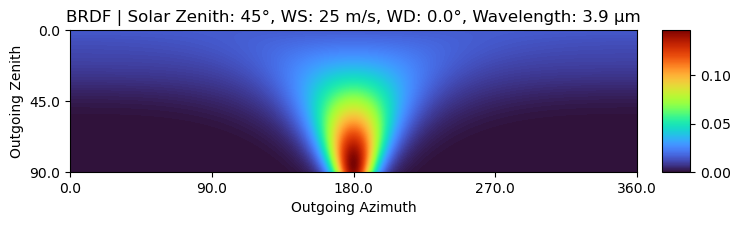

In [365]:
# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
visual_set = [brdf_data, foam_data_vis, glint_data_vis, underlight_data_vis]
channel = 0
im = ax.imshow(visual_set[channel], interpolation='spline36', extent=[0, 2 * np.pi, np.pi / 2, 0], cmap='turbo')

# Name the axes
plt.xlabel("Outgoing Azimuth")
plt.ylabel("Outgoing Zenith")

# Add the title
degrees = np.degrees(incoming)

# Round to 2 decimal places
degrees = round(degrees, 2)

# Create x_axis tick labels in degrees
x_ticks = np.linspace(0, 2 * np.pi, 5)
x_labels = np.degrees(x_ticks)
x_labels = [round(label, 2) for label in x_labels]
plt.xticks(x_ticks, x_labels)

# Create y_axis tick labels in degrees
y_ticks = np.linspace(0, np.pi / 2, 3)
y_labels = np.degrees(y_ticks)
y_labels = [round(label, 2) for label in y_labels]
plt.yticks(y_ticks, y_labels)

# Add Title
ax.set_title(f'BRDF | Solar Zenith: {incoming}°, WS: {wind_speed} m/s, WD: {np.degrees(wind_direction)}°, Wavelength: {wavelength} µm')

# Add color bar with same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.show()

In [366]:
# Save the plot
#fig.savefig(f'brdf/brdf_blinn.png', dpi=300)

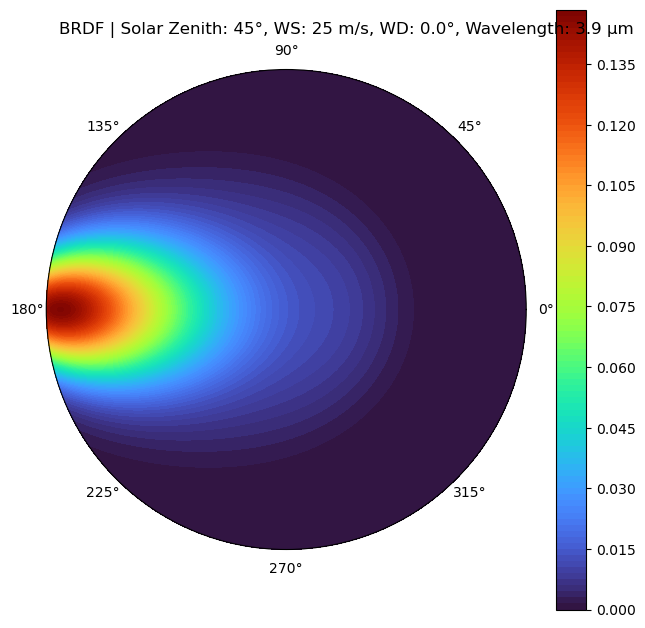

In [367]:
import matplotlib.tri as tri

levels = 128

# Transform zenith into degree
zeniths_deg = np.rad2deg(zeniths_o)

# Create triangulation
x = zeniths_deg * np.cos(azimuths_o)
y = zeniths_deg * np.sin(azimuths_o)
triangles = tri.Triangulation(x, y)

# Make plot
fig = plt.figure(figsize=(6,6))
rect = [0, 0, 1, 1]

# Main plot in Cartesian coordinates
ax_cartesian = fig.add_axes(rect, frameon=False, aspect='equal')
ax_cartesian.axis('off')
ctr = ax_cartesian.tricontourf(triangles, visual_set[channel].T.flatten(), levels=levels, cmap='turbo')

# Show the contours
#ax_cartesian.tricontour(triangles, brdf_data_t, levels=levels, colors='k', linewidths=0.5)

# Match limits with the full zenith range
ax_cartesian.set_xlim([-89, 89])
ax_cartesian.set_ylim([-89, 89])

# Polar axes
ax_polar = fig.add_axes(rect, polar=True, facecolor="none")
ax_polar.set_rlim([0, 89])          # Cover the full zenith value range
ax_polar.grid(False)                # Hide the polar grid
ax_polar.set_yticklabels([])        # No radial tick labels

ax.set_title(f'BRDF | Solar Zenith: {incoming}°, WS: {wind_speed} m/s, WD: {np.degrees(wind_direction)}°, Wavelength: {wavelength} µm')

# Make title visible
plt.suptitle(f'BRDF | Solar Zenith: {incoming}°, WS: {wind_speed} m/s, WD: {np.degrees(wind_direction)}°, Wavelength: {wavelength} µm')

# Add the color bar (important: both axes must be adjusted)
fig.colorbar(ctr, ax=[ax_cartesian, ax_polar])

plt.show()
plt.close()

In [368]:
# Save the plot
fig.savefig(f'../../presentation/ocean_{incoming}_{wind_speed}_{wind_direction}_{wavelength}.png', dpi=300)

## Converting to Polar representation of the BRDF

In [369]:
# Combine zeniths, azimuths and BRDF values into a single array
zeniths = np.array(zeniths_o)
azimuths = np.array(azimuths_o)
brdf_data_new = np.array(brdf_data).T.flatten()
data = np.stack([zeniths, azimuths, brdf_data_new], axis=1)

# Remove rows where the zenith (first element) is greater than 90 degrees
data = data[data[:, 0] <= np.pi / 2]

# Extract the new values
zeniths_t = data[:, 0]
azimuths_t = data[:, 1]
brdf_data_t = data[:, 2]

### Component Share Visualisation

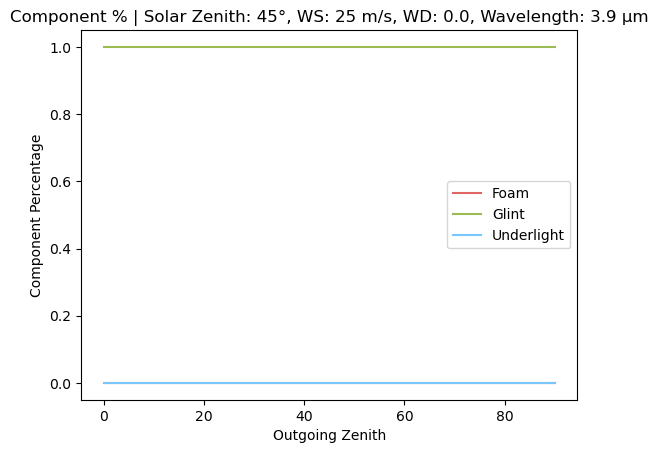

In [370]:
# Visualize component values
slice_azimuth = np.deg2rad(180)

# Find the index of the slice azimuth
t = slice_azimuth / (2 * np.pi)
slice_index = int(t * 2 * res)

# Extract the slice
slice_foam_data = foam_data[slice_index, :]
slice_glint_data = glint_data[slice_index, :]
slice_underlight_data = underlight_data[slice_index, :]

# Plot the slice
fig, ax = plt.subplots()

# Plot the slice by rescaling the x-axis between 0 and 90 degrees
x = np.linspace(0, np.pi / 2, res)

# X to degrees
x = np.degrees(x)

ax.plot(x, slice_foam_data, label='Foam', color='#e06666')
ax.plot(x, slice_glint_data, label='Glint', color='#9dbb53')
ax.plot(x, slice_underlight_data, label='Underlight', color='#78c7ff')

ax.set_xlabel('Outgoing Zenith')
ax.set_ylabel('Component Percentage')
ax.set_title(f'Component % | Solar Zenith: {incoming}°, WS: {wind_speed} m/s, WD: {np.degrees(wind_direction)}, Wavelength: {wavelength} µm')

# Show the legend
ax.legend()

plt.show()

In [371]:
# Save the plot
fig.savefig(f'../../presentation/ocean_{incoming}_{wind_speed}_{wind_direction}_{wavelength}_comp.png', dpi=300)